In [1]:
import numpy as np
import pandas as pd
import scipy as scp
import scipy.stats as ss
from scipy.optimize import newton
import scipy.optimize as opt
from functools import partial
from scipy.stats import norm
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
#from bs4 import BeautifulSoup
import requests
import lxml.html as lh
import re
from datetime import date
import xlsxwriter
from openpyxl.workbook import Workbook
from openpyxl import load_workbook
from openpyxl.chart import ScatterChart, Reference, Series, legend
from openpyxl.chart.layout import Layout, ManualLayout
%matplotlib inline

In [2]:
import os
path = "C:/Users/EliseN.PBUCC"
os.chdir(path)

In [30]:
driver = webdriver.Chrome()
 
etf_list = ['SPY', 'IWM','DIA', 'TLT', 'QQQ', 'GLD']
stock_list=['WMT','MRK','AZN','KO','PG','T','V',
              'NFLX','GOOG','MSFT','FB', 'AAPL','TSLA',
              'AMZN', 'LVS','UAL','AAL','MPC','NCLH','RCL']
r=0.0012      # risk free rate
#'QCOM, ,'VZ','AAL','HAL','RTX','IWM','PFE','ANTM', 'MA','QQQ', 'GLD','BA','WMT''

#Get dividends list and S0 list
q_dict = {}
S0_dict ={}
beta_dict = {}
upslope_dict={}
downslope_dict={}
convex_dict={}

#Get q, S0, beta for ETFs:
for ticker in etf_list:
    driver.get(url = 'https://finance.yahoo.com/quote/'+ticker+'?p='+ticker)
    #WebDriverWait(driver, 20).Until(ExpectedConditions.UrlToBe("my-url"))
    WebDriverWait(driver, 15).until(EC.visibility_of_element_located((By.XPATH, '/html/body/div[1]/div/div/div[1]/div/div[3]/div[1]/div/div[1]/div/div/div/div[2]/div[2]/table/tbody/tr[6]/td[2]/span')))
    beta= driver.find_element_by_xpath('/html/body/div[1]/div/div/div[1]/div/div[3]/div[1]/div/div[1]/div/div/div/div[2]/div[2]/table/tbody/tr[6]/td[2]/span').text
    if beta =='N/A':
        beta = '0'
    beta = float(beta)
    beta_dict.update({ticker: beta})
    
    q= driver.find_element_by_xpath('/html/body/div[1]/div/div/div[1]/div/div[3]/div[1]/div/div[1]/div/div/div/div[2]/div[2]/table/tbody/tr[4]/td[2]/span').text
    if q =='N/A (N/A)':
        q = '(0.00%)'
    q = float(q[0:-1])/100 
    q_dict.update({ticker:q})
    
    WebDriverWait(driver, 15).until(EC.visibility_of_element_located((By.XPATH, '/html/body/div[1]/div/div/div[1]/div/div[2]/div/div/div[4]/div/div/div/div[3]/div/div/span[1]')))
    S0 = driver.find_element_by_xpath("/html/body/div[1]/div/div/div[1]/div/div[2]/div/div/div[4]/div/div/div/div[3]/div[1]/div/span[1]").text 
    S0 = float(S0.replace(',',''))
    S0_dict.update({ticker: S0})
    
# #Get q, S0, beta for stocks:
for ticker in stock_list:
    driver.get('https://finance.yahoo.com/quote/'+ticker+'?p='+ticker)
    WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.XPATH,'/html/body/div[1]/div/div/div[1]/div/div[3]/div[1]/div/div[1]/div/div/div/div[2]/div[2]/table/tbody/tr[6]/td[2]')))
    q= driver.find_element_by_xpath("/html/body/div[1]/div/div/div[1]/div/div[3]/div[1]/div/div[1]/div/div/div/div[2]/div[2]/table/tbody/tr[6]/td[2]").text
    if q =='N/A (N/A)':
        q = '(0.00%)'
    q = float(re.findall(r'\(.*?\)', q)[0][1:-2])/100 
    q_dict.update({ticker:q})
    
    WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.XPATH, '/html/body/div[1]/div/div/div[1]/div/div[3]/div[1]/div/div[1]/div/div/div/div[2]/div[2]/table/tbody/tr[2]/td[2]/span')))
    beta= driver.find_element_by_xpath('/html/body/div[1]/div/div/div[1]/div/div[3]/div[1]/div/div[1]/div/div/div/div[2]/div[2]/table/tbody/tr[2]/td[2]/span').text
    if beta =='N/A':
        beta = '0'
    beta = float(beta)
    beta_dict.update({ticker: beta})
    
    WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.XPATH, '/html/body/div[1]/div/div/div[1]/div/div[2]/div/div/div[4]/div/div/div/div[3]/div/div/span[1]')))
    S0 = driver.find_element_by_xpath("/html/body/div[1]/div/div/div[1]/div/div[2]/div/div/div[4]/div/div/div/div[3]/div[1]/div/span[1]").text
    #S0 = driver.find_element_by_xpath("//span[@class='Trsdu(0.3s) Fw(b) Fz(36px) Mb(-4px) D(ib)']").text                                  
    S0 = float(S0.replace(',',''))
    S0_dict.update({ticker: S0}) 

driver.close()

    #Determine expiration date and T
today = date.today()

expiration_list = [date(2020,8,21),date(2020,9,18), date(2020,10,16),date(2020,11,20),date(2020,12,18)]
expiration_str = ['August 21, 2020','September 18, 2020','October 16, 2020', 'November 20, 2020', 'December 18, 2020']
expiration_urls = ['1597968000','1600387200', '1602806400','1605830400','1608249600']

for i in range(0,len(expiration_list)):
    if (today-expiration_list[i]).days<=0:
        expiration = expiration_list[i]
        expi_str= expiration_str[i]
        expi_url = expiration_urls[i]
        break
    else: 
        expiration = expiration_list[i-1]
        expi_str= expiration_str[i-1]
        expi_url = expiration_urls[i-1]
        
T = (expiration - today).days/365

#Define functions to use

def BlackScholes(S,K,r,q, T,sigma, option):
    d1= (np.log(S/K) + (r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2= d1-sigma*np.sqrt(T)
    if option =="Call":
        return S*np.exp(-q*T)*norm.cdf(d1)-np.exp(-r*T)*K*norm.cdf(d2)
    elif option =="Put": 
        return -S*np.exp(-q*T)*norm.cdf(-d1)+np.exp(-r*T)*K*norm.cdf(-d2)

def impliedVol(Opt_price, S0,K,r,q,T, vol_guess, option):
    try:
        return newton(func = lambda sigma:BlackScholes(S0,K,r,q,T, sigma, option=option)-Opt_price,
                      x0 = vol_guess,
                      tol = 1e-8)
    except:
        try:
            return newton(func = lambda sigma:BlackScholes(S0,K,r,q,T, sigma,option=option)-Opt_price, x0 = vol_guess)
        except:
            return vol_guess
        

<ipython-input-30-0f476051032e>:88: RuntimeWarning: divide by zero encountered in double_scalars
  d1= (np.log(S/K) + (r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
<ipython-input-30-0f476051032e>:88: RuntimeWarning: divide by zero encountered in double_scalars
  d1= (np.log(S/K) + (r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
<ipython-input-30-0f476051032e>:88: RuntimeWarning: divide by zero encountered in double_scalars
  d1= (np.log(S/K) + (r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
<ipython-input-30-0f476051032e>:88: RuntimeWarning: divide by zero encountered in double_scalars
  d1= (np.log(S/K) + (r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
<ipython-input-30-0f476051032e>:88: RuntimeWarning: divide by zero encountered in double_scalars
  d1= (np.log(S/K) + (r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
<ipython-input-30-0f476051032e>:88: RuntimeWarning: divide by zero encountered in double_scalars
  d1= (np.log(S/K) + (r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
<ipython-input-30-0f476051032e>:88: RuntimeWarning: divide

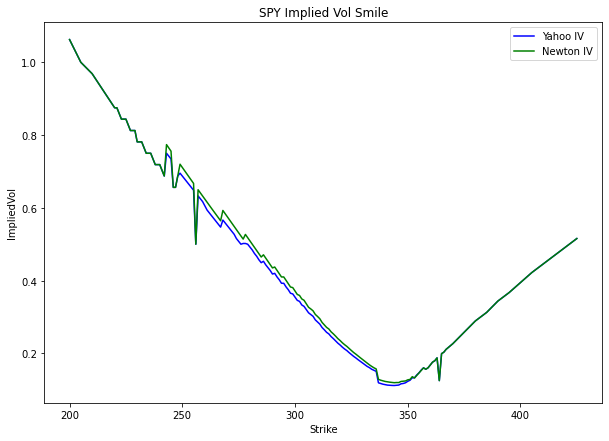

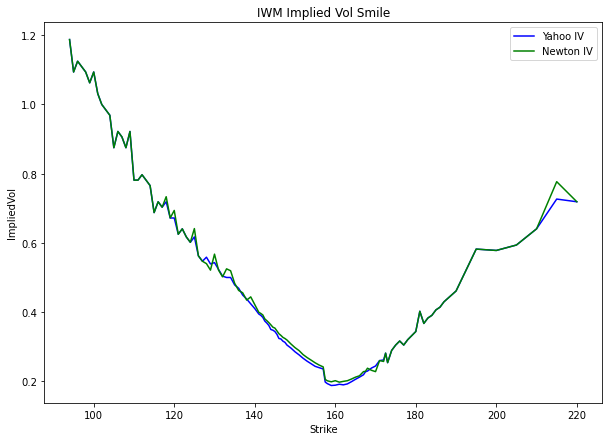

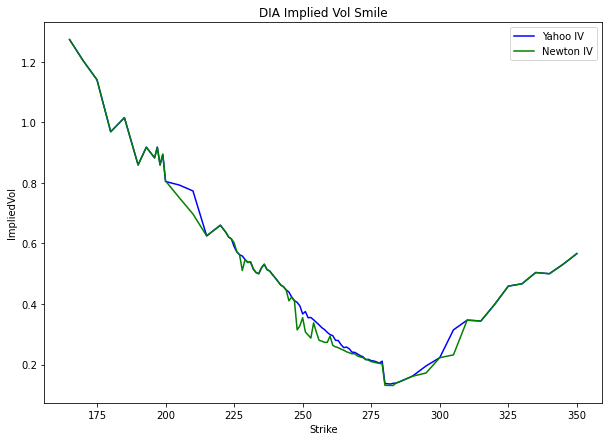

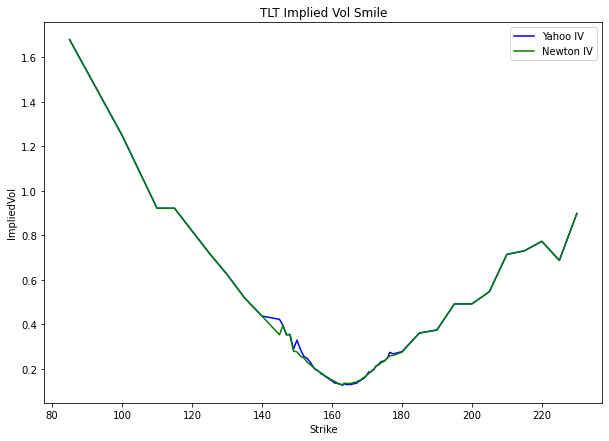

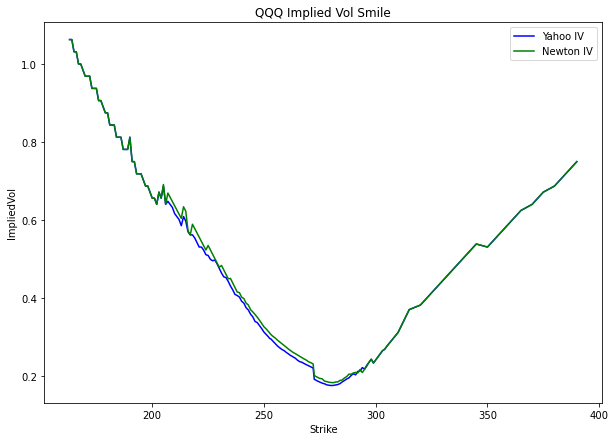

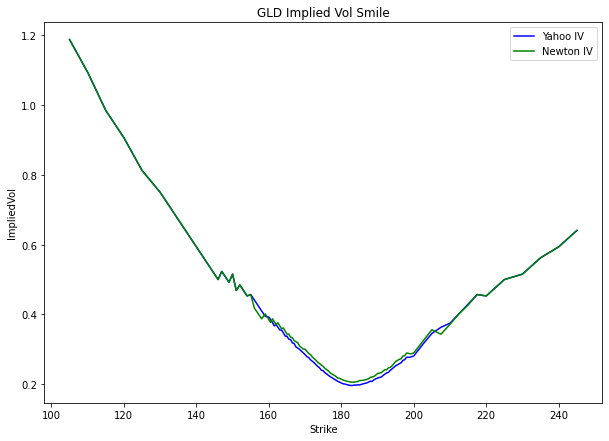

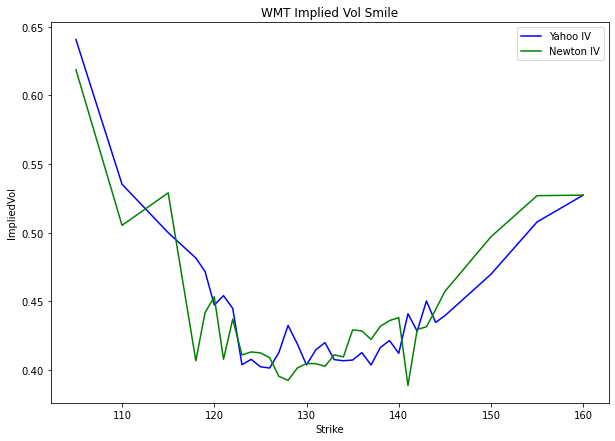

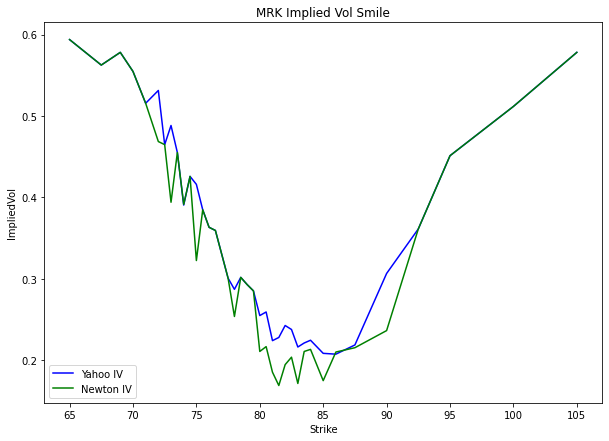

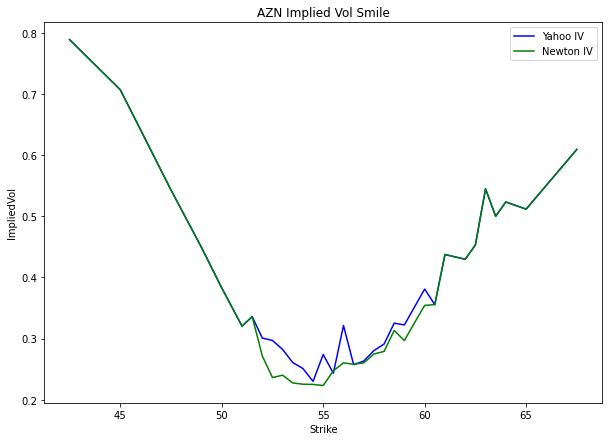

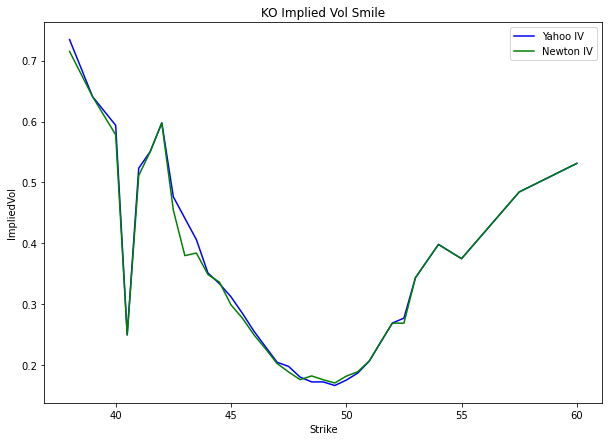

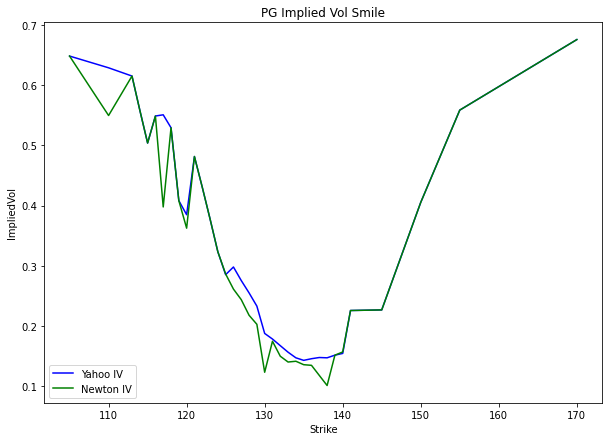

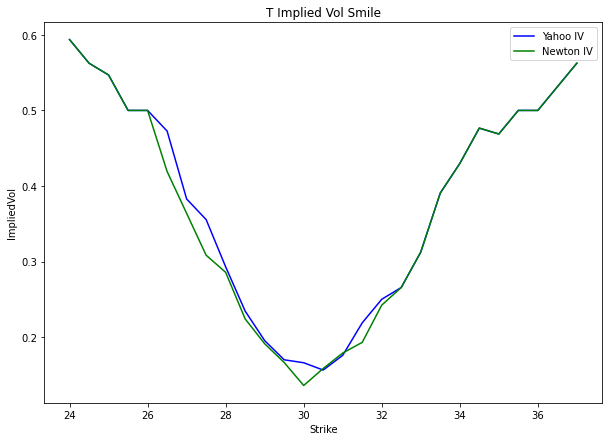

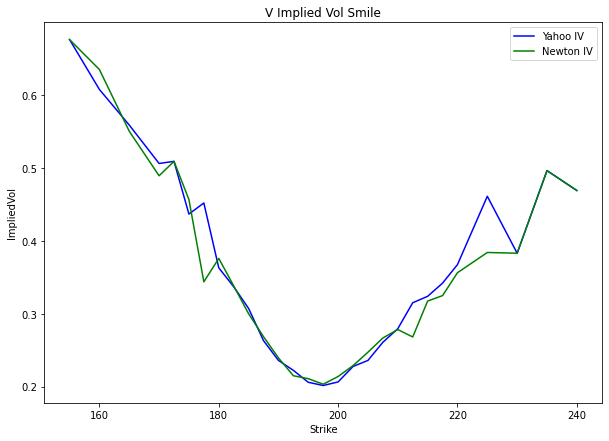

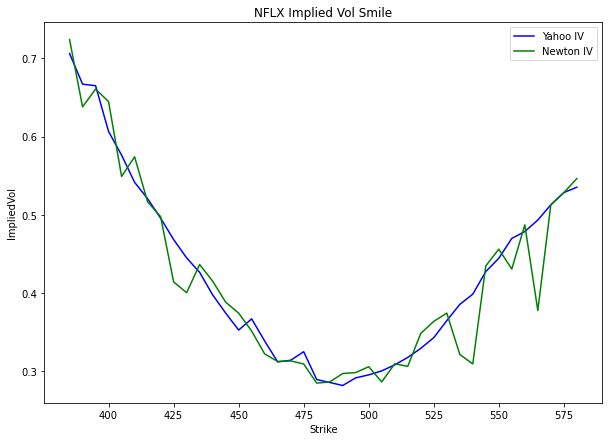

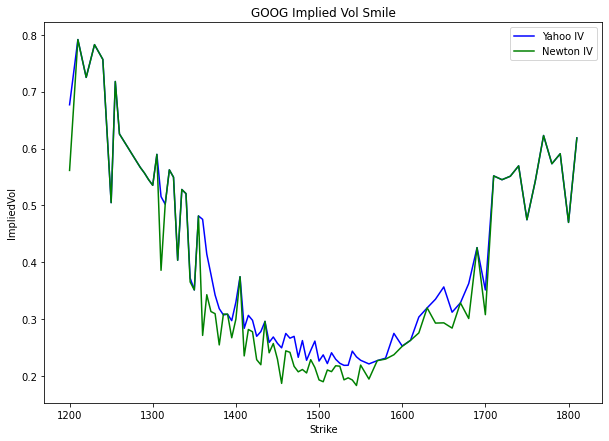

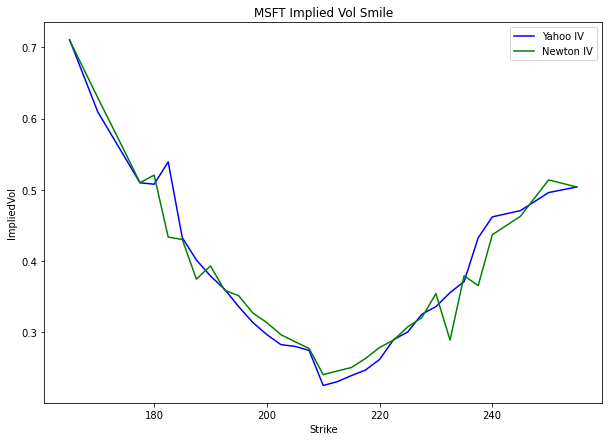

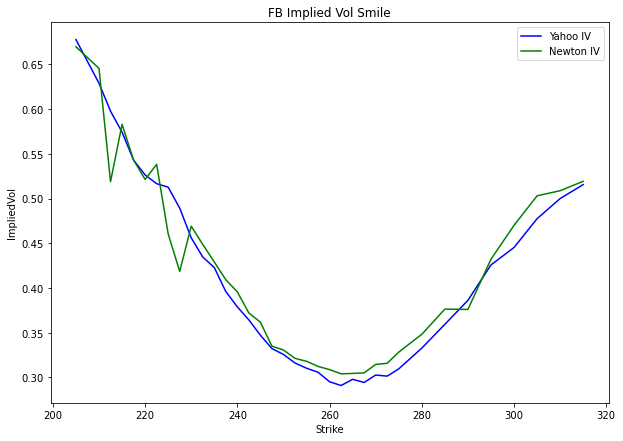

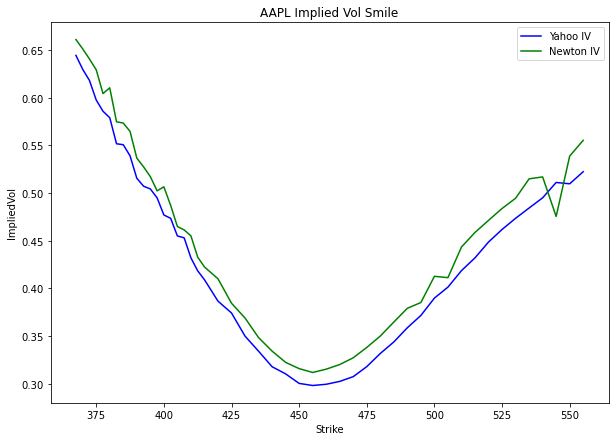

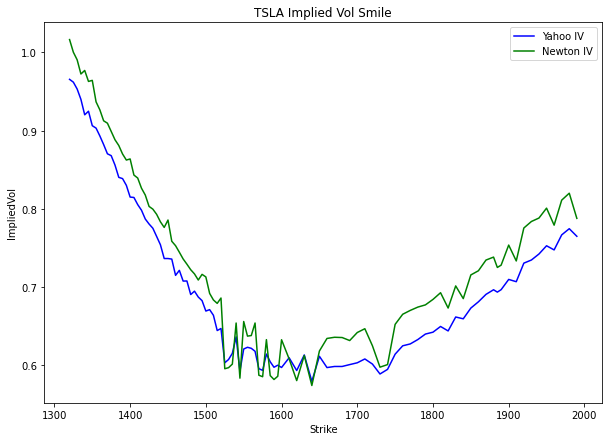

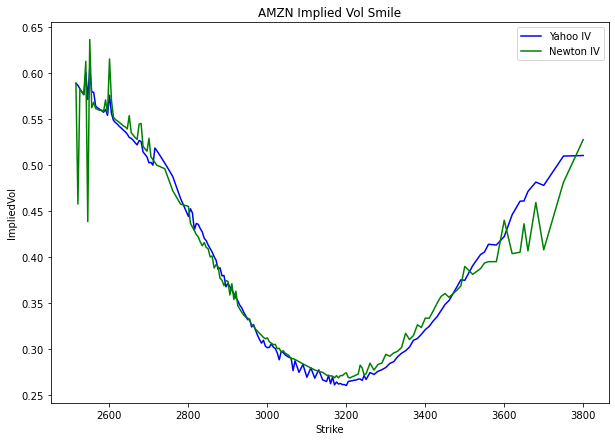

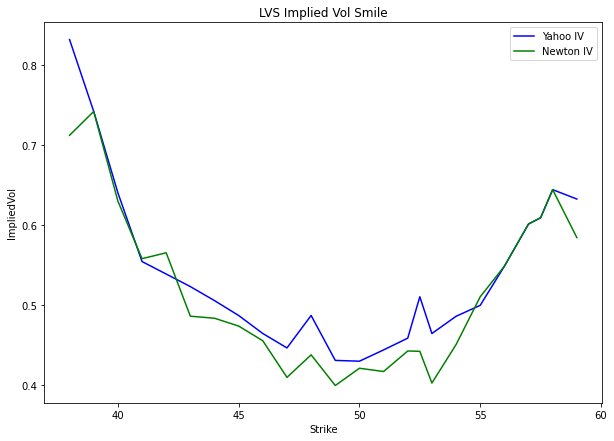

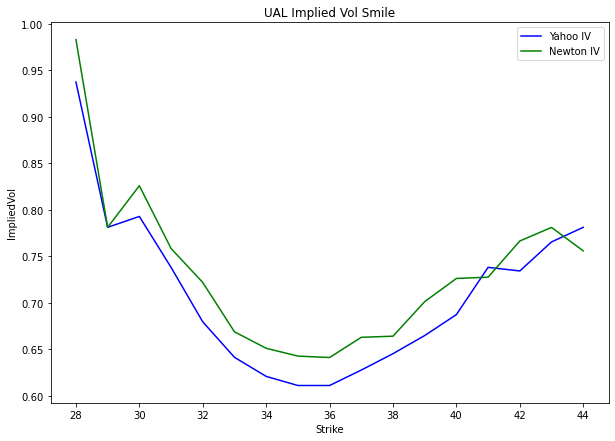

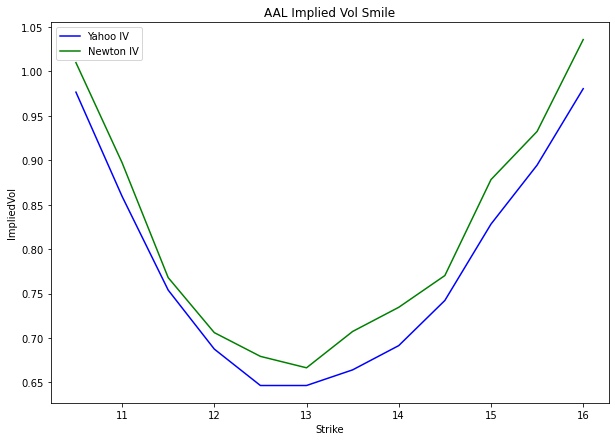

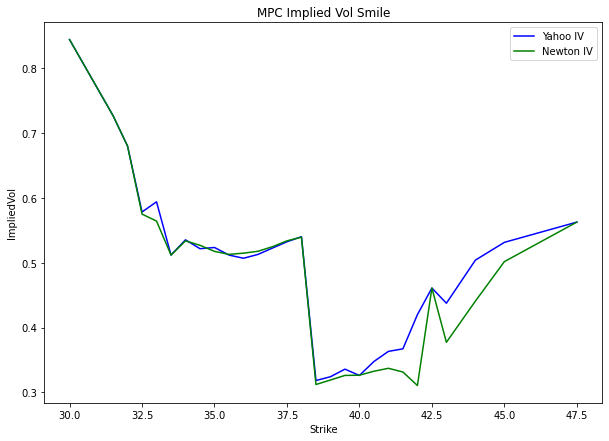

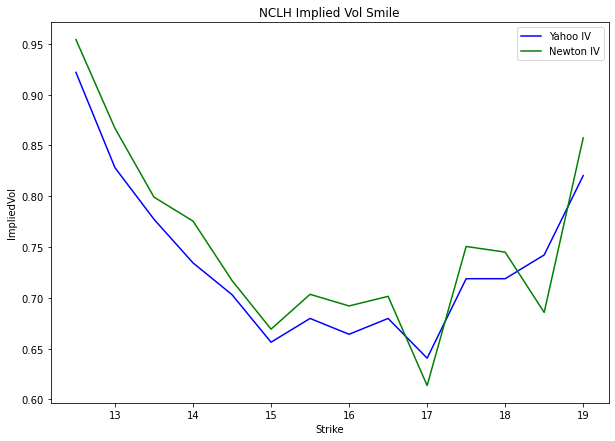

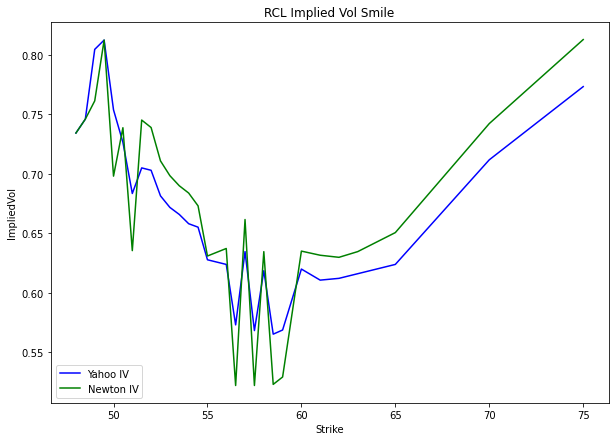

In [31]:

#Get Options data

def vol_calc(ticker, ticker_list):
    S0= S0_dict.get(ticker)
    q= q_dict.get(ticker)
        
    #driver.get('https://finance.yahoo.com/quote/'+ticker+'/options?p='+ticker+'&date='+expi_url)
    url ='https://finance.yahoo.com/quote/'+ticker+'/options?p='+ticker+'&date='+expi_url
    #select = Select(driver.find_element_by_xpath("//select[@class='Fz(s)']"))
    # select by visible text
    #select.select_by_visible_text(expi_str) 
    
    #WebDriverWait(driver, 15).until(EC.visibility_of_element_located((By.XPATH, '/html/body/div[1]/div/div/div[1]/div/div[3]/div[1]/div/div[2]/div/div/section/section[2]/div[1]/span[1]/span')))
    #Create a handle, page, to handle the contents of the website
    #page = requests.get(driver.current_url)
    page = requests.get(url)
    #Store the contents of the website under doc
    doc = lh.fromstring(page.content)
    #Parse data that are stored between <tr>..</tr> of HTML
    tr_elements = doc.xpath('//tr')
    [len(Tr) for Tr in tr_elements[:12]]
    tr_elements = doc.xpath('//tr')
    #Create empty list
    col=[]
    i=0
    #For each row, store each first element (header) and an empty list
    for t in tr_elements[0]:
        i+=1
        name=t.text_content()
        #print('%d:"%s"'%(i,name))
        col.append((name,[]))

    #Since out first row is the header, data is stored on the second row onwards
    for j in range(1,len(tr_elements)):
        #T is our j'th row
        Tr=tr_elements[j]

        #If row is not of size 4, the //tr data is not from our table 
        if len(Tr)!=11:
            break
        #i is the index of our column
        i=0
        #Iterate through each element of the row
        for t in Tr.iterchildren():
            data=t.text_content() 
            #Check if row is empty
            if i>0:
            #Convert any numerical value to integers
                try:
                    data=int(data)
                except:
                    pass
            #Append the data to the empty list of the i'th column
            col[i][1].append(data)
            #Increment i for the next column
            i+=1

    #Process df_ticker and print out to csv
    Dict={title:column for (title,column) in col}
    df_ticker=pd.DataFrame(Dict) 

    df_ticker = df_ticker.drop(index = df_ticker[df_ticker['Bid']=='-'].index)
    #Div: index of division between Call and put                       
    div = df_ticker[df_ticker['Contract Name']=='Contract Name'].index.tolist()[0]
    df_ticker = df_ticker.drop(index = df_ticker[df_ticker['Contract Name']=='Contract Name'].index)
    
    #Processing data
    df_ticker['Strike'] = [float(x.replace(',','')) for x in df_ticker['Strike']]
    df_ticker['Bid'] = [float(x.replace(',','')) for x in df_ticker['Bid']]
    df_ticker['Implied Volatility'] = [float(x[:-1].replace(',','')) for x in df_ticker['Implied Volatility']]
    df_ticker['Implied Volatility'] = df_ticker['Implied Volatility']/100
    df_ticker = df_ticker.reset_index(drop = True)
    
    #Calculate Newton Vol
    Newtonvol_call=[impliedVol(C, S0,K,r,q,T, vol_guess =sig, option = 'Call') for C,K,sig in zip(df_ticker.loc[0:div]['Bid'],df_ticker[0:div]['Strike'], df_ticker[0:div]['Implied Volatility'])]
    Newtonvol_put =[impliedVol(C, S0,K,r,q,T, vol_guess =sig, option = 'Put') for C,K,sig in zip(df_ticker.loc[div:]['Bid'],df_ticker[div:]['Strike'], df_ticker[div:]['Implied Volatility'])]
    s1 = pd.Series(Newtonvol_call+Newtonvol_put, name = 'Newton Vol')
    df_ticker = pd.concat([df_ticker, s1], axis = 1)
    
    #Calculate BS
    BS_call = [BlackScholes(S0,K,r,q,T, sigma, option = 'Call') for K,sigma in zip(df_ticker[0:div]['Strike'], df_ticker[0:div]['Implied Volatility'])]
    BS_put = [BlackScholes(S0,K,r,q,T, sigma, option = 'Put') for K,sigma in zip(df_ticker[div:]['Strike'], df_ticker[div:]['Implied Volatility'])]
    df_ticker = pd.concat([df_ticker, pd.Series(BS_call+BS_put, name = 'BS price')], axis = 1)
    df_ticker['Price Delta'] = df_ticker['BS price'] - df_ticker['Bid']
    df_ticker['Newton Vol Delta'] = df_ticker['Implied Volatility']-df_ticker['Newton Vol']
    
    #Calculating ISp metrics
    df_ticker['ISp']=df_ticker['Newton Vol']-df_ticker['Newton Vol'].shift(1)
    df_ticker['delta_ISp']=df_ticker['ISp']-df_ticker['ISp'].shift(1)
    #Export all data, incl call and put to Excel
    #df_ticker.to_excel(r'C:\Users\EliseN.PBUCC\Documents\Volatility Studies\Options_'+ticker + '- V2.xlsx')
    
    #Separate into call and put data
    df_call = df_ticker.loc[0:div]
    df_put = df_ticker.loc[div:]
    put_K_reverse = sorted(df_put['Strike'], reverse = True)
#     print(df_call.head())
#     print(df_put.head())

    #Set up variables    
    #Calculate the smile could be to use the put code for strikes<S0, and call code for strikes>S0, then join the two 

    if ticker in etf_list:
    #['SPY', 'IWM','DIA', 'TLT', 'QQQ', 'GLD']:
    #or ticker =='IWM' or ticker == 'DIA' or ticker =='TLT' or ticker =='QQQ' or ticker =='GLD':
        bound = 0.4
    else:
        bound = 0.2
        
    #print(S0*(1-bound), S0*(1+bound))
    Kmin= next((x for x in put_K_reverse if x < S0*(1-bound)), min(put_K_reverse))  # find max strike < S0*(1-bound)
    Kmax = next((x for x in df_call['Strike'] if x >= S0*(1+bound)), max(df_call['Strike']))       # find min strike > S0*(1+bound)
    Katm_call = next((x for x in df_call['Strike'] if x >= S0))
    Katm_put = next((x for x in put_K_reverse if x <= S0))
    #print(Kmin, Kmax, Katm_call, Katm_put)
    
    Kmin_index = df_put[df_put['Strike']==Kmin].index.tolist()[0]
    Kmax_index = df_call[df_call['Strike']==Kmax].index.tolist()[0]
    Katm_call_index = df_call[df_call['Strike']==Katm_call].index.tolist()[0]
    Katm_put_index = df_put[df_put['Strike']==Katm_put].index.tolist()[0]
    #print(Kmin_index, Kmax_index, Katm_call_index, Katm_put_index)
    
    #Joining the relevant part of DF within the bounds to plot
    df = df_ticker.loc[Kmin_index:Katm_put_index].append(df_ticker.loc[Katm_call_index:Kmax_index])
    
    Klist = df['Strike']
    Clist = df['Bid']
    siglist = df['Implied Volatility']
    newtonIV = df['Newton Vol']

    #Draw Yahoo Implied Vol
    plt.rcParams.update({'figure.max_open_warning': 0}) #Surpress warnings
    figure=plt.figure(figsize=(10,7))
    plt.plot(Klist, siglist, color = 'blue', label =  'Yahoo IV')
    plt.xlabel("Strike"); plt.ylabel("ImpliedVol"); plt.title(ticker + " Implied Vol Smile")
    
    #Draw Implied vol from Newton
    line_NV = plt.plot(Klist, newtonIV, color='green', label ="Newton IV")
    plt.legend()
        
    #Start excel file and write contents to excel

    dateTimeObj = datetime.now()
    timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H-%M)")
    
    #Write both call and put data into Options - ticker files
    #df_ticker.to_excel(r'C:\Users\EliseN.PBUCC\Documents\Volatility Studies\Options - '+ticker + '.xlsx')
    
    #Write data and charts in Options_Chart - ticker files and whole data set into Options - ticker file
#     p2 = r'C:\Users\EliseN.PBUCC\Documents\Volatility Studies\Options - '+ticker + '.xlsx'
#     book2 = load_workbook(p2)
#     writer2 = pd.ExcelWriter(p2, engine='openpyxl')
#     writer2.book = book2
#     writer2.sheets = dict((ws.title, ws) for ws in book2.worksheets)
#     df_ticker.to_excel(writer2, sheet_name = timestampStr)
#     workbook2  = writer2.book
#     writer2.save()
    
    p = r'C:\Users\EliseN.PBUCC\Documents\Volatility Studies\Options_Chart - '+ticker + '.xlsx'
    book = load_workbook(p)
    writer = pd.ExcelWriter(p, engine='openpyxl') #use openpyxl to load existing workbook and content 
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
    df.to_excel(writer, sheet_name = timestampStr)
    workbook  = writer.book
    worksheet = book.worksheets[-1]
    
    upslope= np.mean(df_call[df_call['Strike']>=S0]['ISp'])
    downslope = np.mean(df_put[df_put['Strike']<S0]['ISp'])
    convex = np.mean(df_ticker['delta_ISp'])
    upslope_dict.update({ticker:upslope})
    downslope_dict.update({ticker:downslope})
    convex_dict.update({ticker:convex})
        
    worksheet.cell(row=1, column=25).value ='Bounds for strikes are: '+ str(bound)
    worksheet.cell(row=2, column=25).value =ticker + ' Average up-slope is:'
    worksheet.cell(row=3, column=25).value =ticker + ' Average down-slope is:'
    worksheet.cell(row=4, column=25).value =ticker + ' Convexity is:'
    worksheet.cell(row=2, column=26).value =upslope
    worksheet.cell(row=3, column=26).value =downslope
    worksheet.cell(row=4, column=26).value =convex
   
    c1 = ScatterChart()
    c1.height = 12 # default is 7.5
    c1.width = 19
    c1.title = ticker + ' Implied Volatility'
    #c1.style = 10

    c1.y_axis.title = 'IV'
    c1.y_axis.number_format = '0.00%'
    c1.x_axis.title = 'Strike'
    
    n = len(df['Strike'])
    #print(n)
    
    xvalues = Reference(worksheet, min_col = 4, min_row = 2, max_row = len(df['Strike'])+1) 
    yvalues1 = Reference(worksheet, min_col = 12, min_row = 2, max_row = len(df['Strike'])+1)
    yvalues2 = Reference(worksheet, min_col = 13, min_row = 2, max_row = len(df['Strike'])+1)
            
    series1 = Series(values = yvalues1, xvalues = xvalues, title ="Yahoo IV") 
    c1.append(series1)
    series2 = Series(values = yvalues2, xvalues = xvalues, title ="Newton IV") 
    c1.append(series2)
    c1.legend.position = 'b'

    c1.x_axis.scaling.min = min(Klist)*0.9
    c1.x_axis.scaling.max = max(Klist)*1.1
    if min(siglist)>=0:
        c1.y_axis.scaling.min = min(siglist)*0.7
    else: 
        c1.y_axis.scaling.min = min(siglist)*1.1
    c1.y_axis.scaling.max = max(siglist)*1.1
    worksheet.add_chart(c1, "Y7")
    
    # Close the Pandas Excel writer and output the Excel file.
    writer.save()
    
    #driver.close()

#driver = webdriver.Chrome()
for ticker in etf_list:
    vol_calc(ticker, etf_list)
#driver.close()    

#driver = webdriver.Chrome()
for ticker in stock_list:
    vol_calc(ticker, stock_list)
#driver.close()


{'SPY': 1.0, 'IWM': 1.27, 'DIA': 0.99, 'TLT': 3.03, 'QQQ': 1.02, 'GLD': -0.01, 'WMT': 0.32, 'MRK': 0.49, 'AZN': 0.26, 'KO': 0.55, 'PG': 0.44, 'T': 0.66, 'V': 0.88, 'NFLX': 0.94, 'GOOG': 1.04, 'MSFT': 0.9, 'FB': 1.21, 'AAPL': 1.23, 'TSLA': 1.3, 'AMZN': 1.33, 'LVS': 1.55, 'UAL': 1.41, 'AAL': 1.64, 'MPC': 2.19, 'NCLH': 2.61, 'RCL': 2.43}


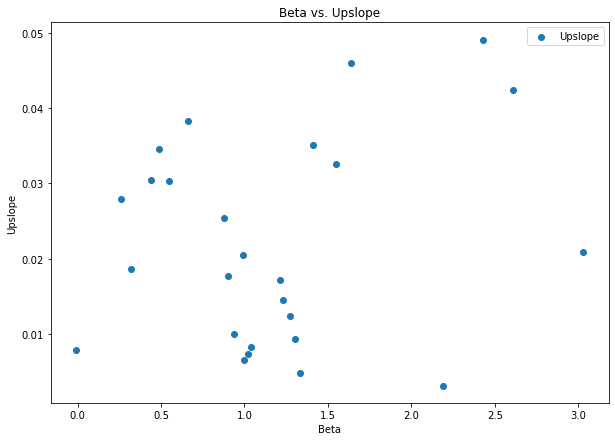

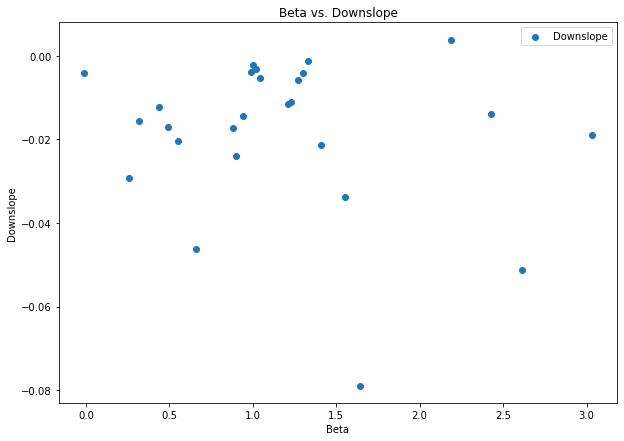

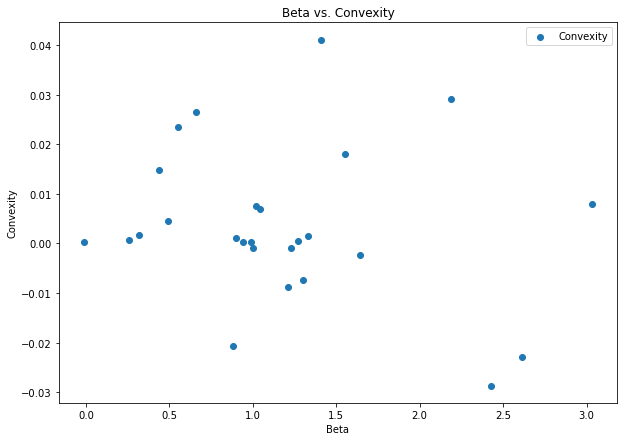

In [16]:
#Draw beta vs. smile metrics

beta_values = list(beta_dict.values())
convex_values = list(convex_dict.values())
upslope_values = list(upslope_dict.values())
downslope_values = list(downslope_dict.values())
print(beta_dict)
#print(upslope_values)
# print(convex_values)
# print(upslope_values)
# print(downslope_values)
figure1 = plt.figure(figsize = (10,7))
plt.scatter(beta_values, upslope_values, label = 'Upslope')
plt.xlabel("Beta"); plt.ylabel("Upslope"); plt.title('Beta vs. Upslope')
plt.legend()
figure2 = plt.figure(figsize = (10,7))
plt.scatter(beta_values, downslope_values, label = 'Downslope')
plt.xlabel("Beta"); plt.ylabel("Downslope"); plt.title('Beta vs. Downslope')
plt.legend()
figure3 = plt.figure(figsize = (10,7))
plt.scatter(beta_values, convex_values, label = 'Convexity')
plt.xlabel("Beta"); plt.ylabel("Convexity"); plt.title('Beta vs. Convexity')
plt.legend()
